In [1]:
# Custom utilities
import NO_utils_multiple
import NO_utils

# Standard libraries
import sys
import os
import time
import random
from datetime import datetime
import hashlib

# Scientific computing
import numpy as np
import scipy as sp

# Deep learning - PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
import torch.optim as optim
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import (
    DataLoader, Dataset, TensorDataset,
    random_split, ConcatDataset
)
from torchvision import transforms

# Neural operator specific
from neuralop.models import FNO, FNO2d, TFNO, TFNO2d
from neuralop import Trainer, LpLoss, H1Loss

# Data processing and visualization
from sklearn.preprocessing import StandardScaler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Progress tracking
from tqdm import tqdm

In [2]:
# Force garbage collection to release file handles
import gc
gc.collect()

291

## Load and visualize data

In [3]:
current_dir = os.getcwd()
reduced_dataset = os.path.join(current_dir, 'data', 'reduced', 'test_continuous_1000', 'reduced_datasettest_continuous_1000_ws4_bs2_f32.pt')
# Load all 16 datasets
dataset = torch.load(reduced_dataset)

# Print info about each dataset
print("Dataset:")
print(f"Type: {type(dataset)}")
print(f"Length: {len(dataset)}")
if hasattr(dataset, 'tensors'):
    for i, tensor in enumerate(dataset.tensors):
        print(f"Tensor {i}: shape {tensor.shape}, dtype {tensor.dtype}")
print("\n")

C:\Users\hz283\AppData\Local\Temp\ipykernel_20576\2803154299.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(reduced_dataset)


Dataset:
Type: <class 'torch.utils.data.dataset.TensorDataset'>
Length: 243000
Tensor 0: shape torch.Size([243000, 3, 32, 32]), dtype torch.float32
Tensor 1: shape torch.Size([243000, 4, 32, 32]), dtype torch.float32




In [4]:
def visualize_sample(input_tensor, output_tensor, target_tensor):
    """
    Visualize input and output tensors from a single sample.
    
    Args:
        input_tensor: Tensor of shape (3, H, W) containing input components
        output_tensor: Tensor of shape (4, H, W) containing output components
        (optional) target_tensor: Tensor of shape (4, H, W) containing target components
    """
    # Create figure for input components
    fig1 = plt.figure(figsize=(12, 4))

    # Plot input tensor components (1x3 subplot)
    for i in range(3):
        plt.subplot(1, 3, i+1)
        im = plt.imshow(input_tensor[i].abs().numpy())
        plt.colorbar(im)
        plt.title(f'Input Component {i+1}')

    plt.tight_layout()
    plt.show()

    # Create figure for output components 
    fig2 = plt.figure(figsize=(16, 4))

    # Plot output tensor components (1x4 subplot)
    for i in range(4):
        plt.subplot(1, 4, i+1)
        im = plt.imshow(output_tensor[i].abs().numpy())
        plt.colorbar(im)
        plt.title(f'Output Component {i+1}')

    plt.tight_layout()
    plt.show()

    # Create figure for target components
    if target_tensor is not None:
        fig3 = plt.figure(figsize=(16, 4))
        for i in range(4):
            plt.subplot(1, 4, i+1)
            im = plt.imshow(target_tensor[i].abs().numpy())
            plt.colorbar(im)
            plt.title(f'Target Component {i+1}')

        plt.tight_layout()
        plt.show()

Input tensor type: <class 'torch.Tensor'>
Input tensor shape: torch.Size([3, 32, 32])
Output tensor type: <class 'torch.Tensor'>
Output tensor shape: torch.Size([4, 32, 32])
Visualizing random sample 152489


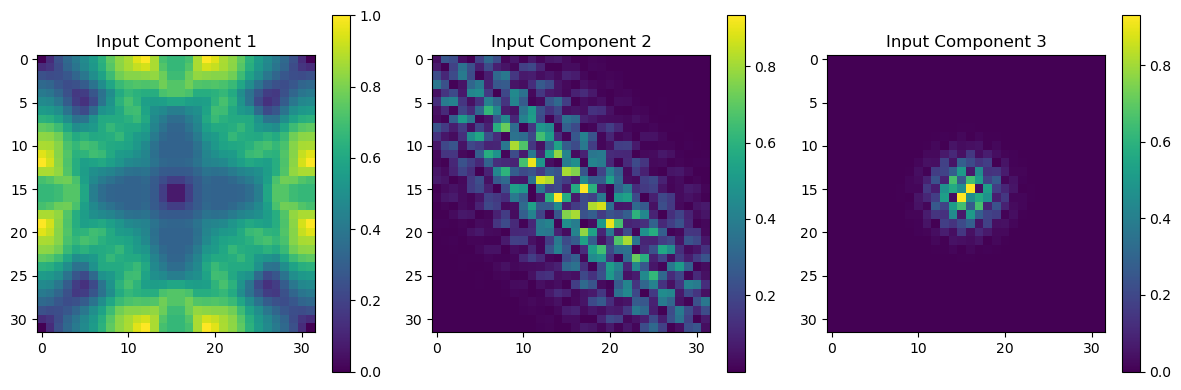

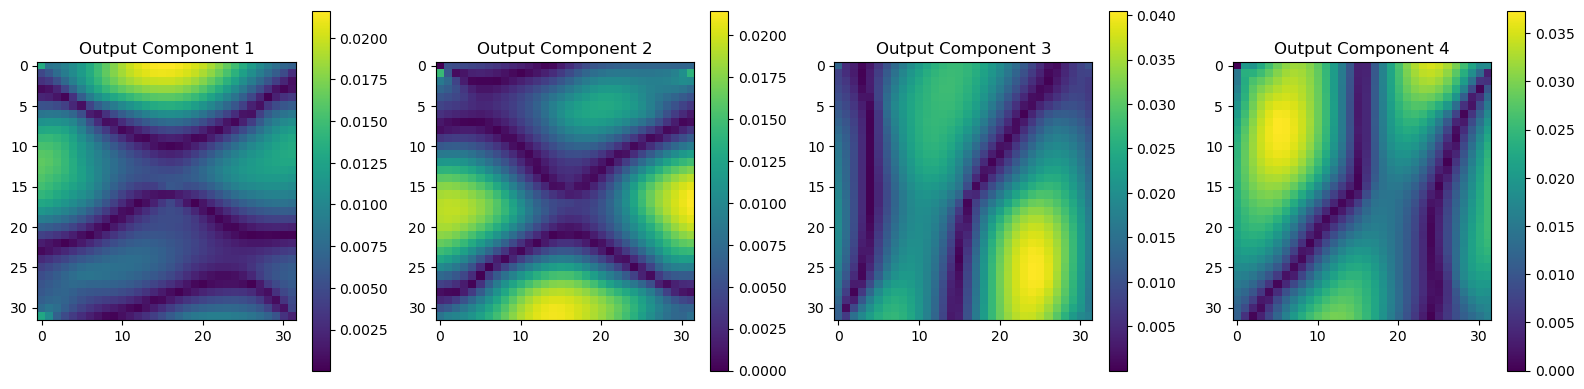

In [5]:
# Get a random sample from the dataset
random_idx = np.random.randint(0, len(dataset))
sample = dataset[random_idx]

# Extract input and output tensors from the sample
input_tensor = sample[0]  # First element is input
output_tensor = sample[1] # Second element is output

# Print type and shape of input_tensor and output_tensor
print("Input tensor type:", type(input_tensor))
print("Input tensor shape:", input_tensor.shape)
print("Output tensor type:", type(output_tensor))
print("Output tensor shape:", output_tensor.shape)

print(f"Visualizing random sample {random_idx}")
visualize_sample(input_tensor, output_tensor, None)

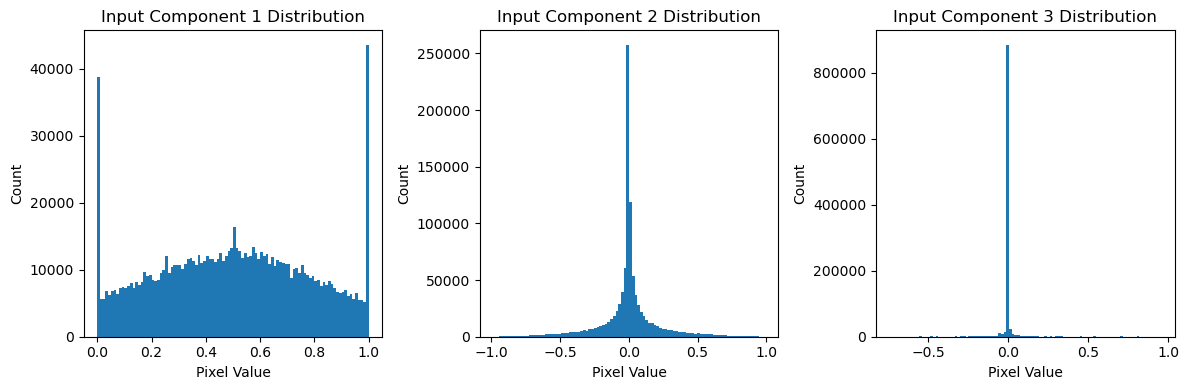

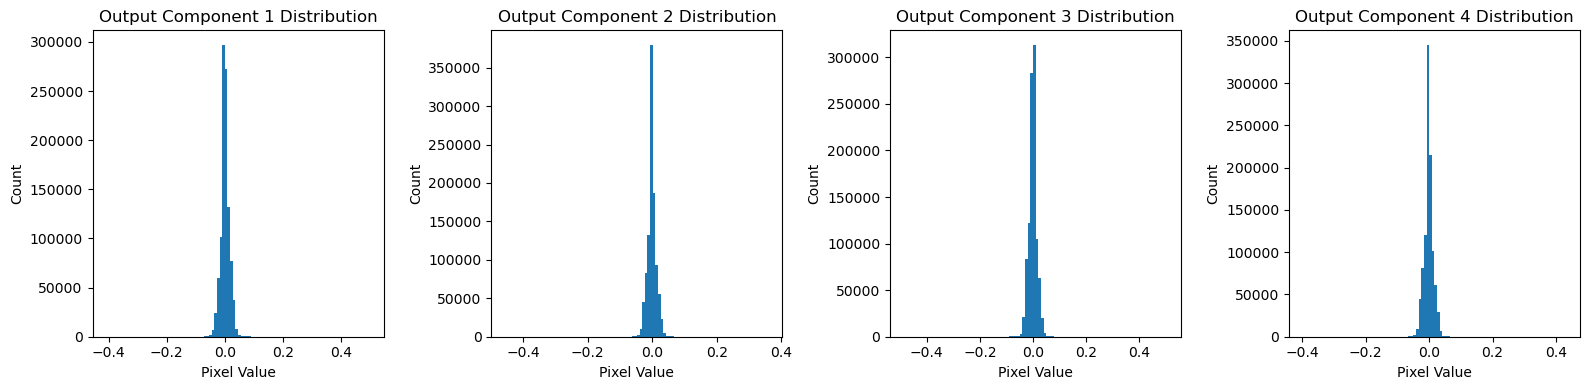

In [6]:
# Create arrays to store all pixel values across dataset
input_pixels = [[] for _ in range(3)]  # 3 input components
output_pixels = [[] for _ in range(4)] # 4 output components

# Sample a subset of the dataset for efficiency
num_samples = min(1000, len(dataset))
sample_indices = np.random.choice(len(dataset), num_samples, replace=False)

# Collect pixel values
for idx in sample_indices:
    sample = dataset[idx]
    input_tensor = sample[0]
    output_tensor = sample[1]
        # Gather input pixels
    for i in range(3):
        input_pixels[i].extend(input_tensor[i].numpy().flatten())
        
    # Gather output pixels
    for i in range(4):
        output_pixels[i].extend(output_tensor[i].numpy().flatten())

# Plot input histograms
fig1 = plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.hist(input_pixels[i], bins=100)
    plt.title(f'Input Component {i+1} Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Plot output histograms
fig2 = plt.figure(figsize=(16, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.hist(output_pixels[i], bins=100)
    plt.title(f'Output Component {i+1} Distribution')
    plt.xlabel('Pixel Value') 
    plt.ylabel('Count')
plt.tight_layout()
plt.show()


## Model evaluation

In [7]:

dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0)

#Set the device for the neural operator model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device:', device)
print("Using PyTorch version:", torch.__version__)


Using Device: cuda
Using PyTorch version: 2.5.1


In [8]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

def compute_dataset_hash(dataset):
    """
    Compute a hash of the dataset by concatenating all image data and bandgap values.
    This ensures that the same dataset will always produce the same hash.
    """
    # Initialize a list to store all data
    all_data = []
    
    # Collect all data from the dataset
    for idx in range(len(dataset)):
        image, bandgap = dataset[idx]  # Modified to unpack 2 values instead of 3
        # Convert tensors to numpy arrays and flatten
        image_np = image.numpy().flatten()
        bandgap_np = bandgap.numpy().flatten()
        
        # Concatenate all data
        sample_data = np.concatenate([image_np, bandgap_np])
        all_data.append(sample_data)
    
    # Concatenate all samples and compute hash
    combined_data = np.concatenate(all_data)
    return hashlib.sha256(combined_data.tobytes()).hexdigest()

def compare_datasets_by_stats(dataset1, dataset2):
    """
    Compare datasets by computing basic statistics.
    This is memory efficient as it processes one sample at a time.
    """
    if len(dataset1) != len(dataset2):
        return False
    
        # Compute mean and std for each dataset
    def compute_stats(dataset):
        image_sum = torch.zeros(dataset[0][0].shape)
        image_sq_sum = torch.zeros(dataset[0][0].shape)
        bandgap_sum = 0
        bandgap_sq_sum = 0
        
        for image, bandgap in dataset:
            image_sum += image
            image_sq_sum += image ** 2
            bandgap_sum += bandgap
            bandgap_sq_sum += bandgap ** 2
            
        n = len(dataset)
        return {
            'image_mean': image_sum / n,
            'image_std': torch.sqrt(image_sq_sum / n - (image_sum / n) ** 2),
            'bandgap_mean': bandgap_sum / n,
            'bandgap_std': torch.sqrt(bandgap_sq_sum / n - (bandgap_sum / n) ** 2)
        }

    stats1 = compute_stats(dataset1)
    stats2 = compute_stats(dataset2)

    # Compare statistics
    for key in stats1:
        if not torch.allclose(stats1[key], stats2[key], rtol=1e-5):
            return False
    return True

def compute_dataset_stats(dataset, batch_size=128):
    """
    Compute mean and std of the entire dataset efficiently using batches.
    Returns both dataset-level and per-image statistics.
    """
    # Initialize accumulators
    dataset_sum = torch.zeros(dataset[0][0].shape)
    dataset_sq_sum = torch.zeros(dataset[0][0].shape)
    total_samples = len(dataset)
    
    # Create a dataloader for efficient batching
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Compute dataset-level statistics
    for images, _ in loader:
        dataset_sum += images.sum(dim=0)
        dataset_sq_sum += (images ** 2).sum(dim=0)
    
    # Compute final statistics
    dataset_mean = dataset_sum / total_samples
    dataset_std = torch.sqrt(dataset_sq_sum / total_samples - dataset_mean ** 2)
    
    # Compute per-image statistics
    # per_image_means = []
    # per_image_stds = []
    
    for images, _ in loader:
        # Compute mean and std for each image in the batch
        batch_means = images.mean(dim=(1, 2))  # Mean across height and width
        batch_stds = images.std(dim=(1, 2))    # Std across height and width
        # per_image_means.extend(batch_means.tolist())
        # per_image_stds.extend(batch_stds.tolist())
    
    return {
        'dataset_mean': dataset_mean,
        'dataset_std': dataset_std,
        # 'per_image_means': per_image_means,
        # 'per_image_stds': per_image_stds
    }

In [9]:
class FourierNeuralOperator(nn.Module):
    def __init__(self, modes_height, modes_width, in_channels, out_channels, hidden, num_layers):
        super(FourierNeuralOperator, self).__init__()
        self.modes_height = modes_height  # Number of Fourier modes in height dimension
        self.modes_width = modes_width  # Number of Fourier modes in width dimension
        self.hidden = hidden  # Width of the hidden channels
        self.in_channels = in_channels  # Number of input channels
        self.out_channels = out_channels  # Number of output channels
        self.num_layers = num_layers

        # FNO2d layer
        self.fno = FNO2d(in_channels=self.in_channels, 
                         out_channels=self.out_channels, 
                         n_modes_height=self.modes_height, 
                         n_modes_width=self.modes_width, 
                         hidden_channels=self.hidden, 
                         n_layers=self.num_layers)

    def forward(self, x):
        # Apply the FNO2d layer
        x = self.fno(x)
        return x

In [10]:
def train_one_epoch(model, loader, criterion, optimizer, device, epoch, report_freq=100, save_after_batch=False, save_path=None):
    model.train()
    running_loss = 0.0
    total_batches = len(loader)
    progress_bar = tqdm(enumerate(loader), total=total_batches, desc=f"Epoch {epoch + 1}")

    for batch_idx, (inputs, targets) in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        # print(f"Model output shape: {outputs.shape}")
        # print(f"Target shape: {targets.shape}")
        # print(f"Number of channels in output: {outputs.shape[1]}")
        # print(f"Data type: {outputs.dtype}")
        # print(f"Range of values: [{outputs.min().item()}, {outputs.max().item()}]")
        loss = criterion(outputs, targets).mean()  # Ensure the loss is a scalar
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Print progress for each batch
        if (batch_idx + 1) % report_freq == 0 or (batch_idx + 1) == total_batches:
            progress_bar.set_postfix(batch_loss=loss.item())

        # Save model weights after each batch if the flag is set
        if save_after_batch and save_path:
            save_model(model, save_path)

    epoch_loss = running_loss / len(loader.dataset)

    # Save model weights after each epoch if the flag is not set
    if not save_after_batch and save_path:
        save_model(model, save_path)

    return epoch_loss

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets).mean()  # Ensure the loss is a scalar
            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

# Function to save the model weights
def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)

# Function to load the model weights
def load_model(model, file_path):
    model.load_state_dict(torch.load(file_path))

In [11]:
def plot_sample(data, title, labels, shared_colorbar=False, vmin=None, vmax=None, layout=None, save=False, save_path='plot.png'):
    # Automatically select layout based on the number of data arrays if not provided
    num_arrays = data.shape[0]
    if layout is None:
        if num_arrays == 3:
            layout = (1, 3)
        elif num_arrays == 4:
            layout = (2, 2)
        else:
            raise ValueError("Data input must have 3 or 4 arrays for plotting.")

    # Adjust figure size based on layout
    if layout == (1, 3):
        fig, axes = plt.subplots(*layout, figsize=(12, 4))  # Wide and short for 1x3 layout
    elif layout == (2, 2):
        fig, axes = plt.subplots(*layout, figsize=(8, 8))   # Square for 2x2 layout
    else:
        raise ValueError("Unsupported layout")

    for ax, (idx, label) in zip(axes.flatten(), labels):
        im = ax.imshow(data[idx, :, :].cpu(), cmap='viridis', vmin=vmin if shared_colorbar else None, vmax=vmax if shared_colorbar else None)
        ax.set_title(label)
        if not shared_colorbar:
            fig.colorbar(im, ax=ax)

    if shared_colorbar:
        # Add a single colorbar to the right of the plot
        cbar = fig.colorbar(im, ax=axes.ravel().tolist())
        cbar.ax.set_ylabel('Color scale')

    plt.suptitle(title)

    if save:
        # Save the figure
        plt.savefig(save_path)
        print(f"Plot saved at {save_path}")
        plt.close(fig)
    else:
        # Display the figure
        plt.show()

def plot_inputs(data, title, labels, save=False, save_path='example_plot.png'):
    # Plot inputs with layout (1, 3) and custom figure size
    plot_sample(data, title, labels, shared_colorbar=True, layout=(1, 3), save=save, save_path=save_path)

def plot_predictions_and_targets(inputs, outputs, targets, save=False, save_dir='figures/', file_suffix='example'):
    # Ensure save directory exists if save is True
    if save:
        os.makedirs(save_dir, exist_ok=True)

    # Add file_suffix to the filenames
    input_filename = f'{save_dir}/input_{file_suffix}.png'
    output_filename = f'{save_dir}/output_{file_suffix}.png'
    target_filename = f'{save_dir}/target_{file_suffix}.png'

    input_labels = [(0, 'geometry'), (1, 'waveform'), (2, 'band')]
    plot_inputs(inputs, 'Inputs', input_labels, save=save, save_path=input_filename)

    # Compute global min and max for shared colorbar between outputs and targets
    vmin = min(np.min(outputs.cpu().numpy()), np.min(targets.cpu().numpy()))
    vmax = max(np.max(outputs.cpu().numpy()), np.max(targets.cpu().numpy()))

    prediction_labels = [(0, 'eigenvector_x_real'), (1, 'eigenvector_x_imag'), (2, 'eigenvector_y_real'), (3, 'eigenvector_y_imag')]
    plot_sample(outputs, "Model Predictions", prediction_labels, shared_colorbar=True, vmin=vmin, vmax=vmax, save=save, save_path=output_filename)

    target_labels = [(0, 'eigenvector_x_real'), (1, 'eigenvector_x_imag'), (2, 'eigenvector_y_real'), (3, 'eigenvector_y_imag')]
    plot_sample(targets, "Target Values", target_labels, shared_colorbar=True, vmin=vmin, vmax=vmax, save=save, save_path=target_filename)


In [12]:
hc = 128; lr = 1e-3; wd = 1e-3; ss = 4; gamma = 0.1; design_res = 32

model = FourierNeuralOperator(modes_height=design_res, modes_width=design_res, in_channels=3, out_channels=4, hidden=hc, num_layers=4).to(device)
#model = model.half()

criterion = nn.MSELoss(reduction='mean') # Use mean squared error loss
#criterion = criterion.half()

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=ss, gamma=gamma)

In [13]:
current_state_dict = model.state_dict()
print("Current model keys:", list(current_state_dict.keys()))
print("Number of current model keys:", len(current_state_dict.keys()))

Current model keys: ['fno.fno_blocks.convs.0.bias', 'fno.fno_blocks.convs.0.weight.tensor', 'fno.fno_blocks.convs.1.bias', 'fno.fno_blocks.convs.1.weight.tensor', 'fno.fno_blocks.convs.2.bias', 'fno.fno_blocks.convs.2.weight.tensor', 'fno.fno_blocks.convs.3.bias', 'fno.fno_blocks.convs.3.weight.tensor', 'fno.fno_blocks.fno_skips.0.conv.weight', 'fno.fno_blocks.fno_skips.1.conv.weight', 'fno.fno_blocks.fno_skips.2.conv.weight', 'fno.fno_blocks.fno_skips.3.conv.weight', 'fno.fno_blocks.channel_mlp.0.fcs.0.weight', 'fno.fno_blocks.channel_mlp.0.fcs.0.bias', 'fno.fno_blocks.channel_mlp.0.fcs.1.weight', 'fno.fno_blocks.channel_mlp.0.fcs.1.bias', 'fno.fno_blocks.channel_mlp.1.fcs.0.weight', 'fno.fno_blocks.channel_mlp.1.fcs.0.bias', 'fno.fno_blocks.channel_mlp.1.fcs.1.weight', 'fno.fno_blocks.channel_mlp.1.fcs.1.bias', 'fno.fno_blocks.channel_mlp.2.fcs.0.weight', 'fno.fno_blocks.channel_mlp.2.fcs.0.bias', 'fno.fno_blocks.channel_mlp.2.fcs.1.weight', 'fno.fno_blocks.channel_mlp.2.fcs.1.bias',

In [14]:
load_path = './models/model_L2_random_subset_hc128_lr1e-03_wd1e-03_ss4_gamma1e-01_e24.pth'
load_existing_model = True
if load_existing_model and os.path.isfile(load_path):
    try:
        # Load the state dict
        state_dict = torch.load(load_path, map_location=device)
        
        # Remove any metadata keys
        if isinstance(state_dict, dict):
            # Remove any keys that start with underscore (metadata)
            state_dict = {k: v for k, v in state_dict.items() if not k.startswith('_')}
        
        # Load the cleaned state dict
        model.load_state_dict(state_dict)
        print(f"Loaded model weights from {load_path}")
        
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Model will start with random weights")

C:\Users\hz283\AppData\Local\Temp\ipykernel_20576\814869186.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(load_path, map_location=device)


Loaded model weights from ./models/model_L2_random_subset_hc128_lr1e-03_wd1e-03_ss4_gamma1e-01_e24.pth


In [15]:
# Use the loaded model to run through one batch of the dataloader and plot predictions in a 2x2 plot

# Get a batch from the validation loader
inputs, targets = next(iter(dataloader))
inputs, targets = inputs.to(device), targets.to(device)

# Set model to eval mode and get predictions
model.eval()
with torch.no_grad():
    outputs = model(inputs)

# Move data to cpu and convert to numpy for plotting
inputs_np = inputs.cpu()
targets_np = targets.cpu()
outputs_np = outputs.cpu()

# Print type and shape of inputs, outputs, and targets
print("Inputs type:", type(inputs))
print("Inputs shape:", inputs.shape)
print("Outputs type:", type(outputs))
print("Outputs shape:", outputs.shape)
print("Targets type:", type(targets))
print("Targets shape:", targets.shape)

# Randomly sample 10 indices from the batch and visualize each sample
batch_size = inputs_np.shape[0]
num_samples = 10
random_indices = np.random.choice(batch_size, size=num_samples, replace=False)

# for idx in random_indices:
#     print(f"Visualizing sample {idx}")
#     input_sample = inputs_np[idx]
#     output_sample = outputs_np[idx]
#     target_sample = targets_np[idx]
#     # Print max and min of input, output, and target
#     print(f"Input max: {input_sample.max():.4f}, min: {input_sample.min():.4f}")
#     print(f"Output max: {output_sample.max():.4f}, min: {output_sample.min():.4f}")
#     print(f"Target max: {target_sample.max():.4f}, min: {target_sample.min():.4f}")
#     print(f"Target scale (max - min): {target_sample.max() - target_sample.min():.4f}")
#     # Compute average absolute error per pixel between output and target
#     avg_abs_error = torch.mean(torch.abs(output_sample - target_sample)).item()
#     print(f"Average absolute error per pixel (output vs target): {avg_abs_error:.6f}")
#     visualize_sample(input_sample, output_sample, target_sample)


Inputs type: <class 'torch.Tensor'>
Inputs shape: torch.Size([256, 3, 32, 32])
Outputs type: <class 'torch.Tensor'>
Outputs shape: torch.Size([256, 4, 32, 32])
Targets type: <class 'torch.Tensor'>
Targets shape: torch.Size([256, 4, 32, 32])


Visualizing sample 228


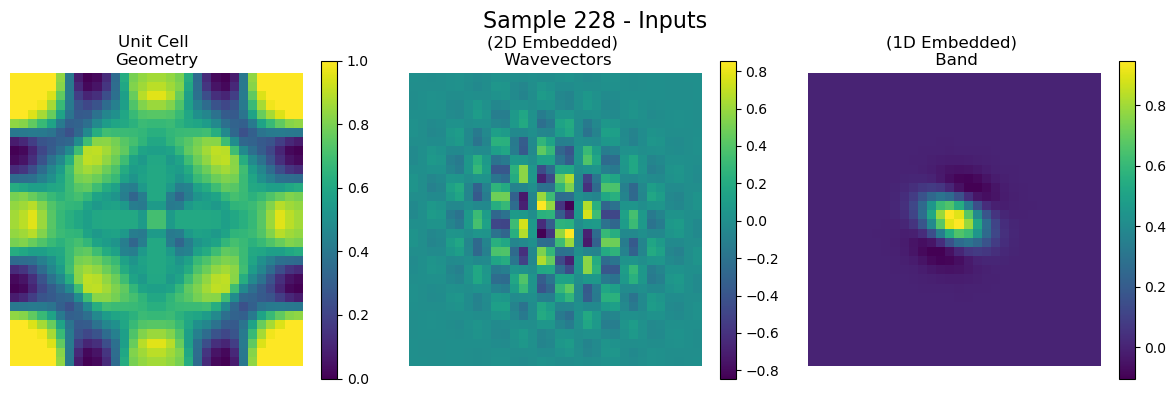

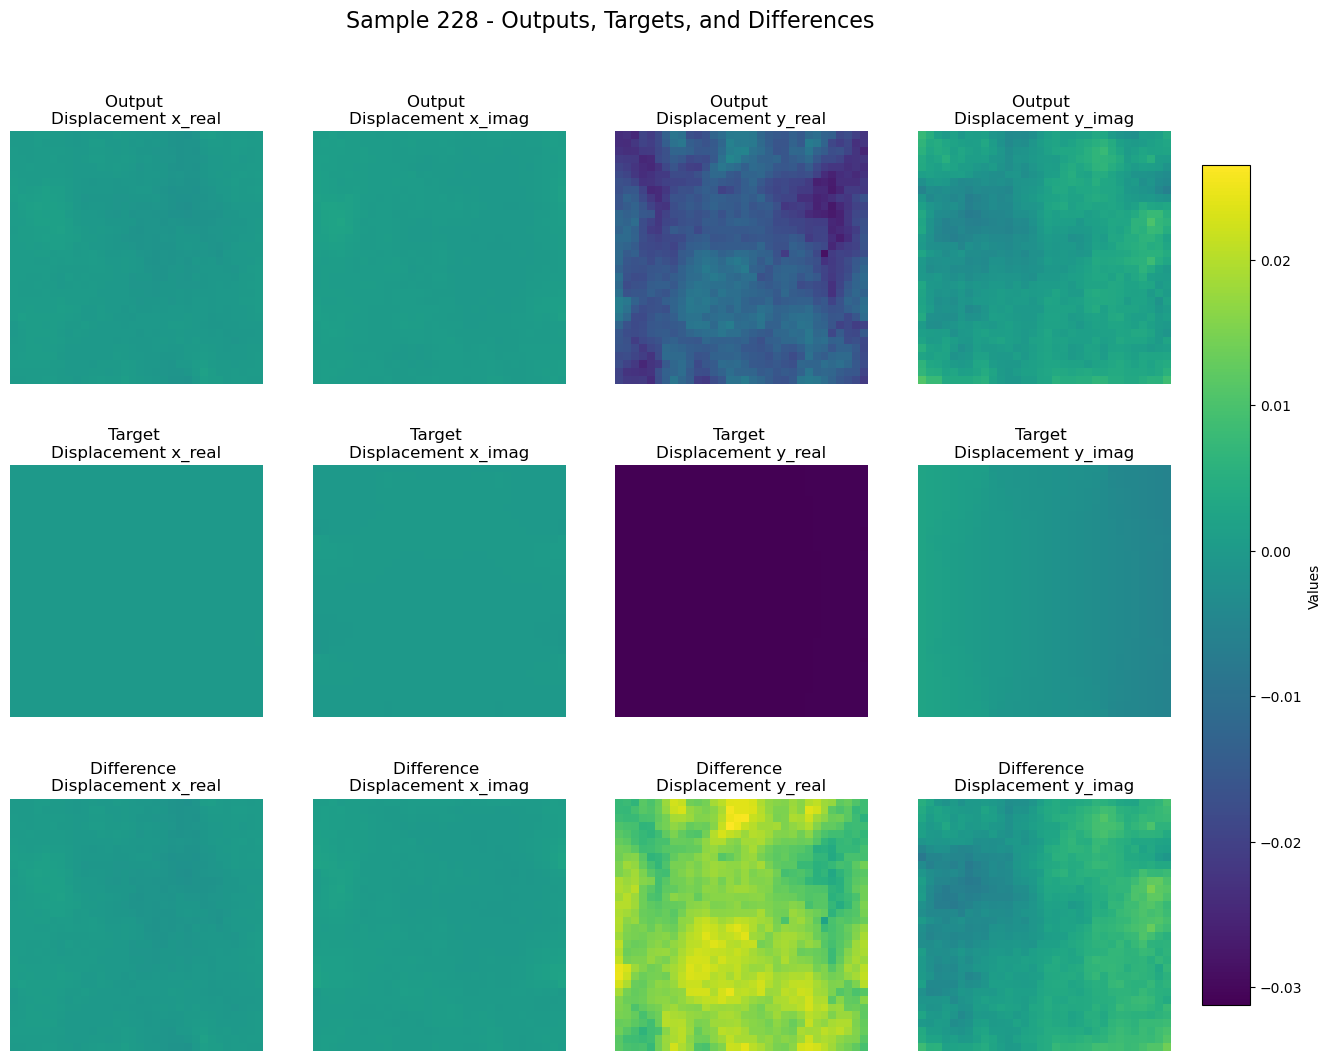

Visualizing sample 6


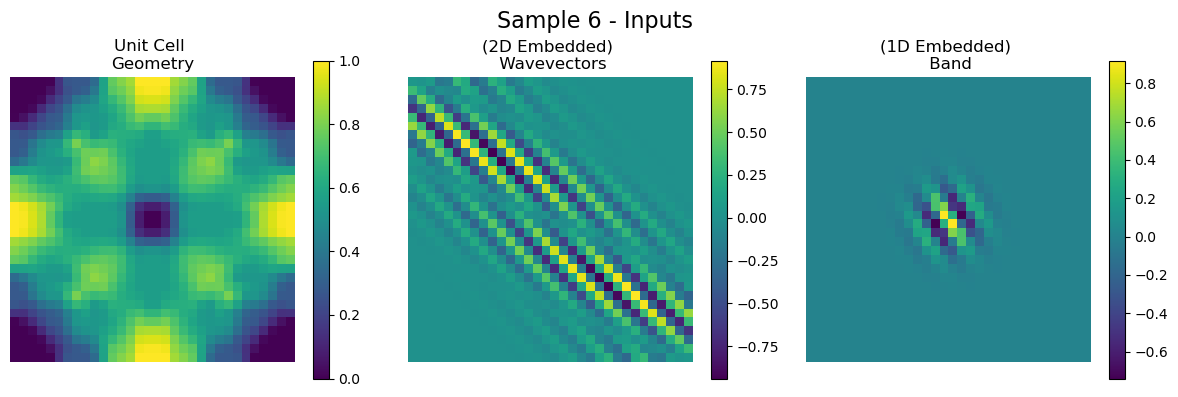

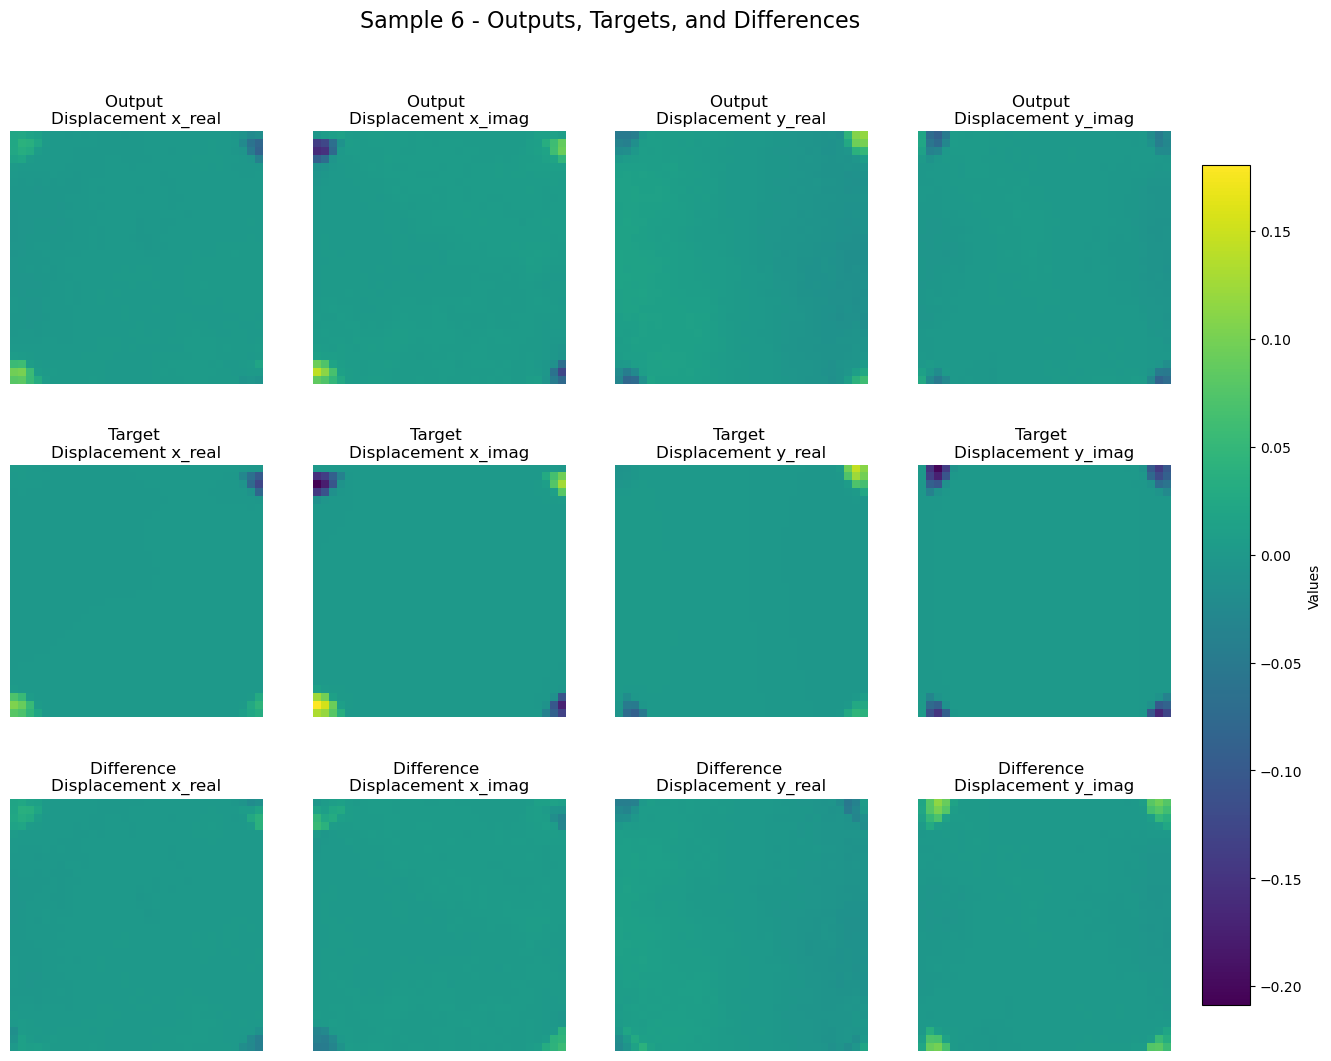

Visualizing sample 79


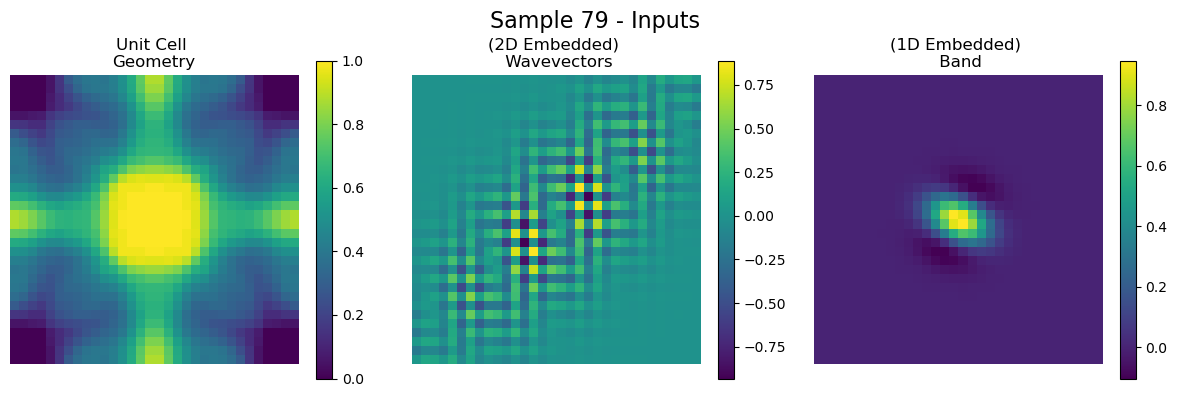

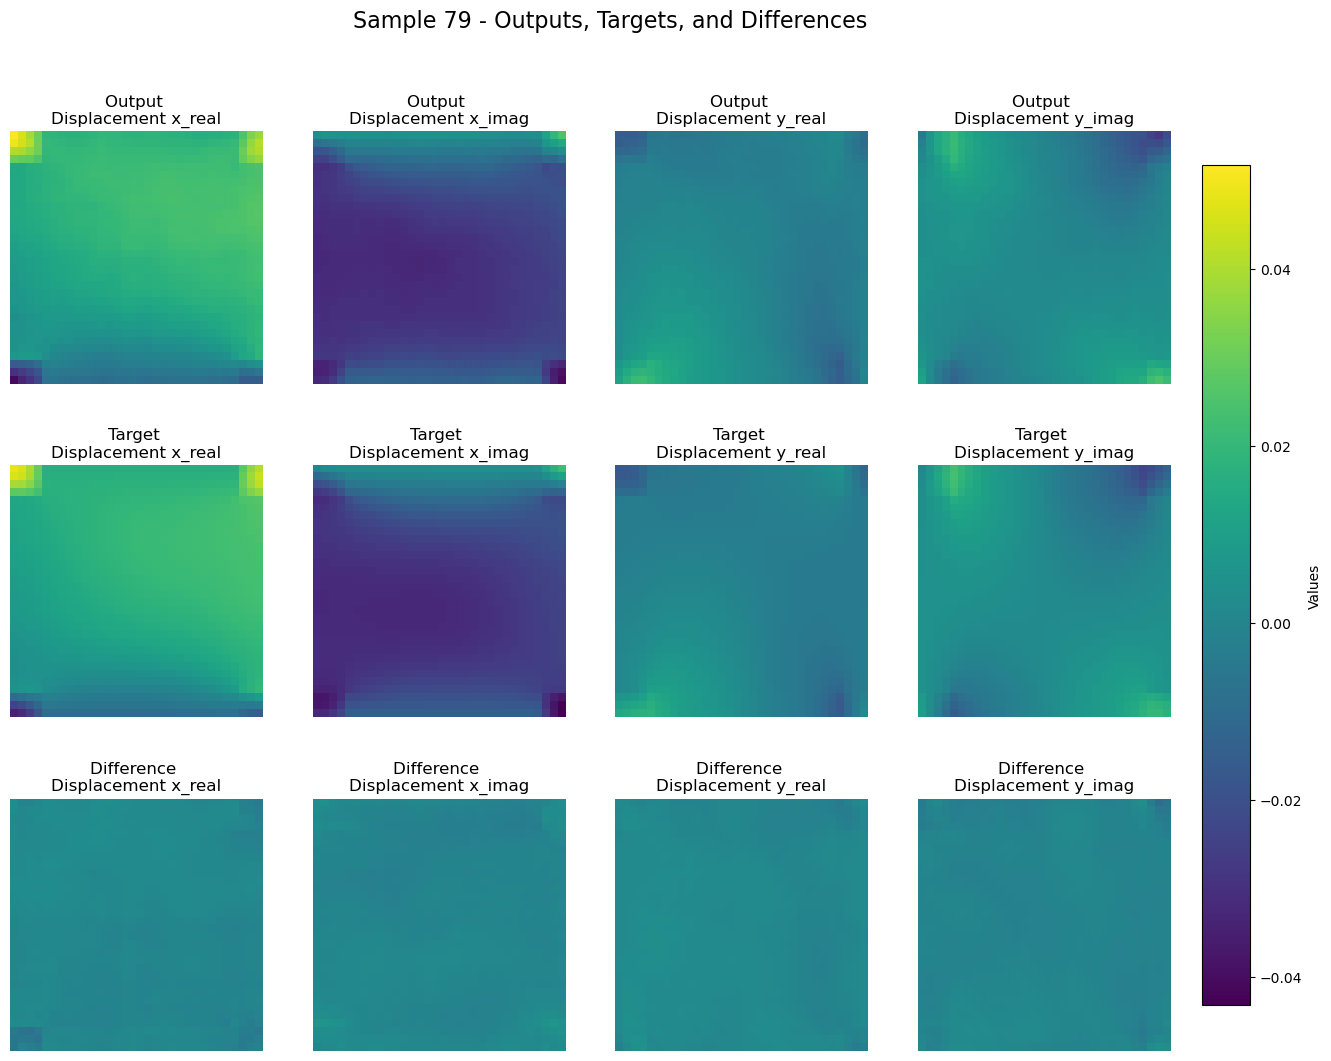

Visualizing sample 206


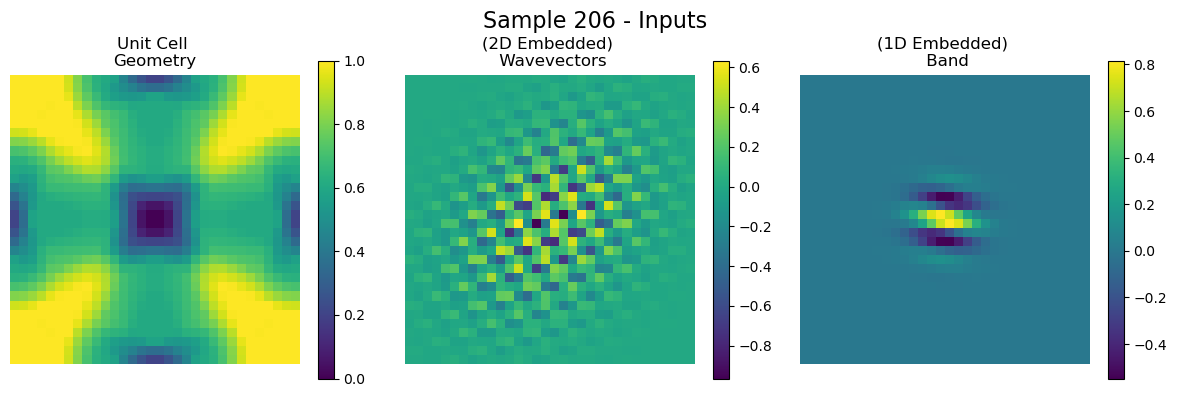

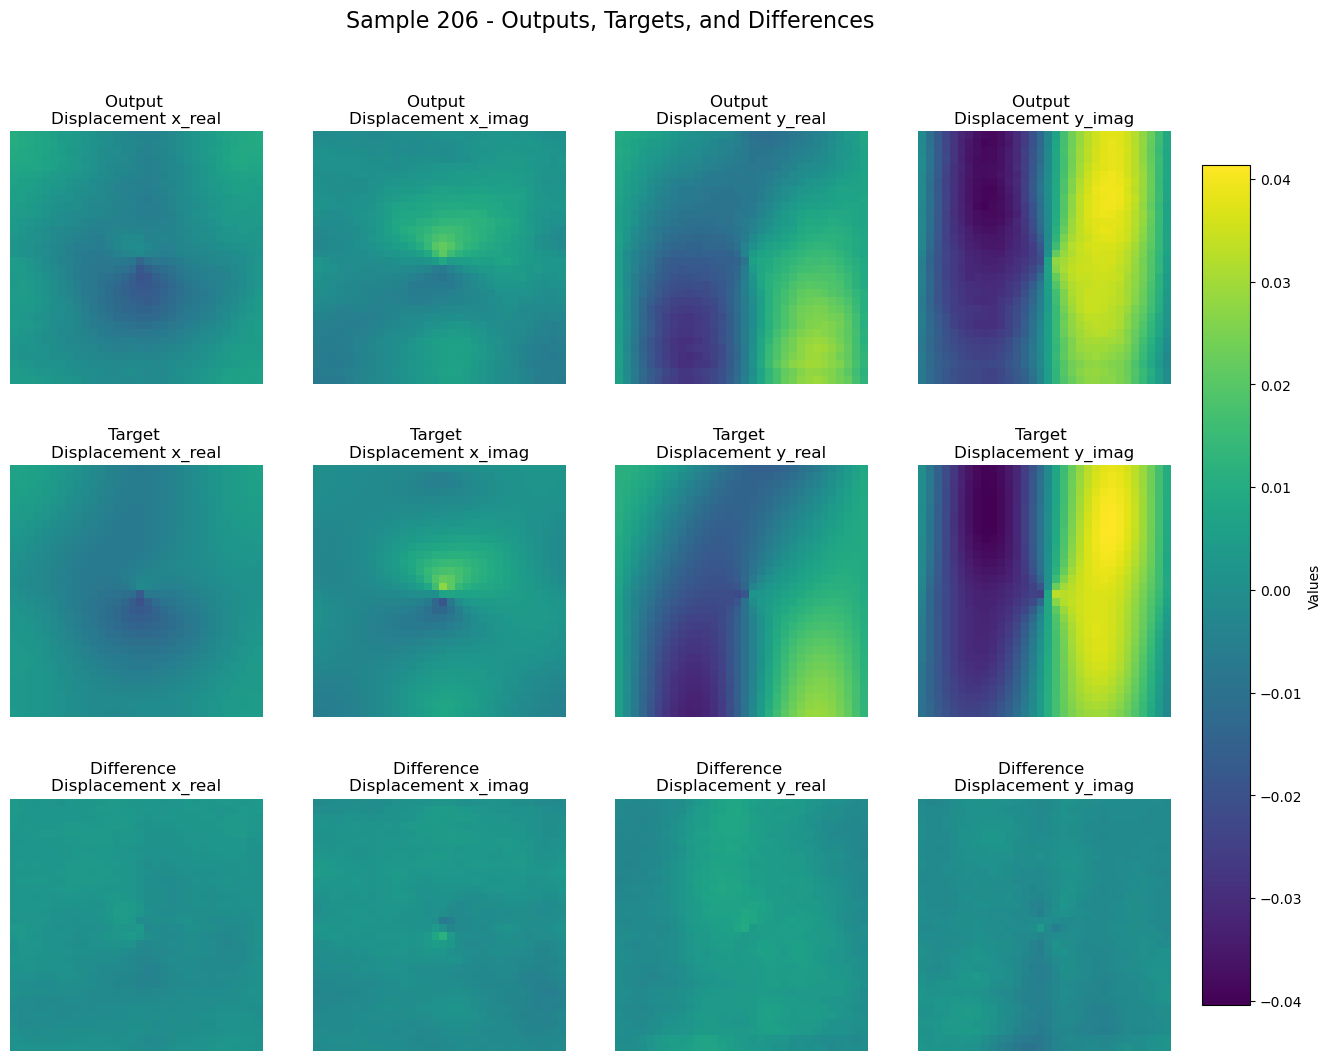

Visualizing sample 117


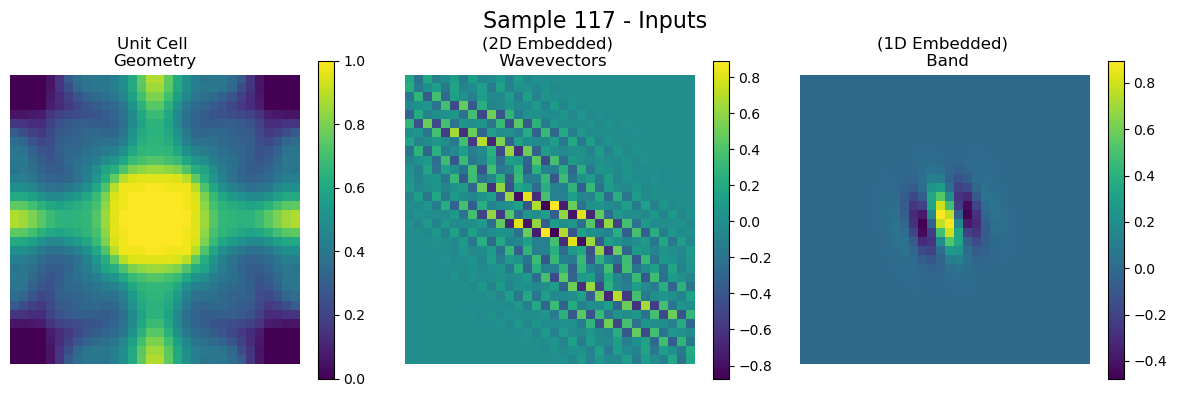

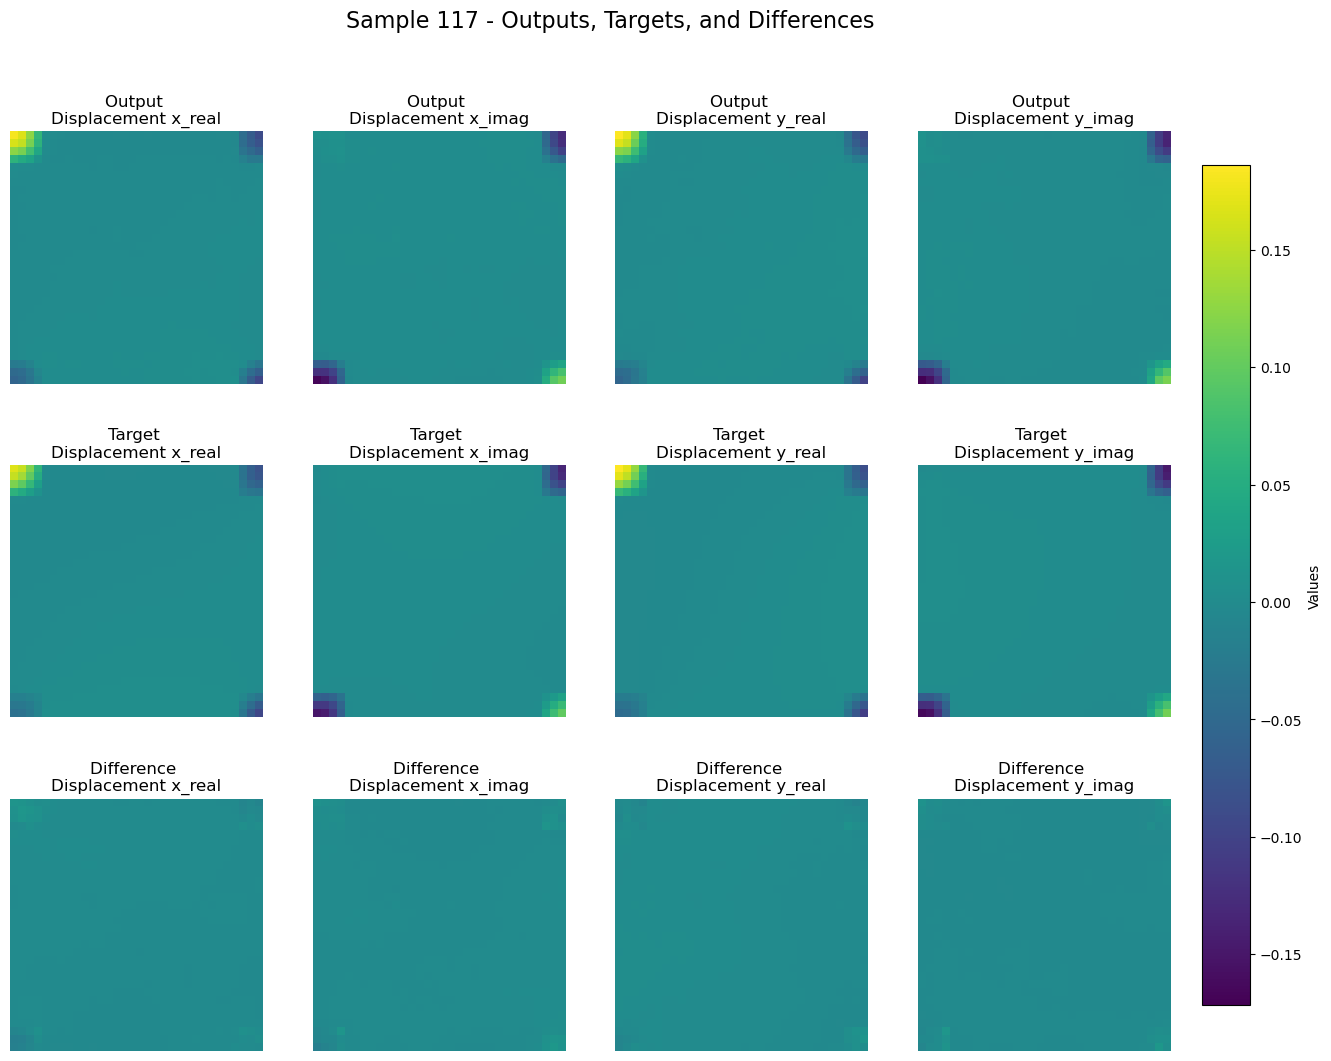

Visualizing sample 185


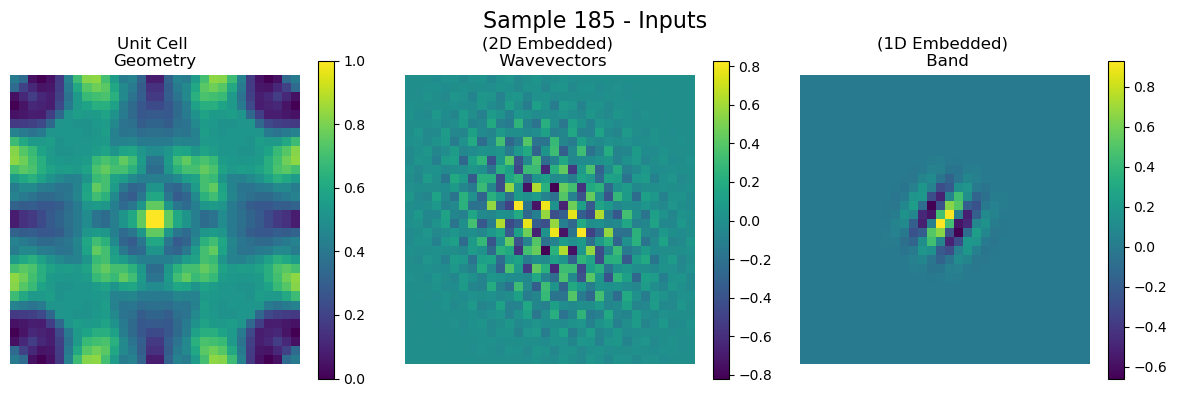

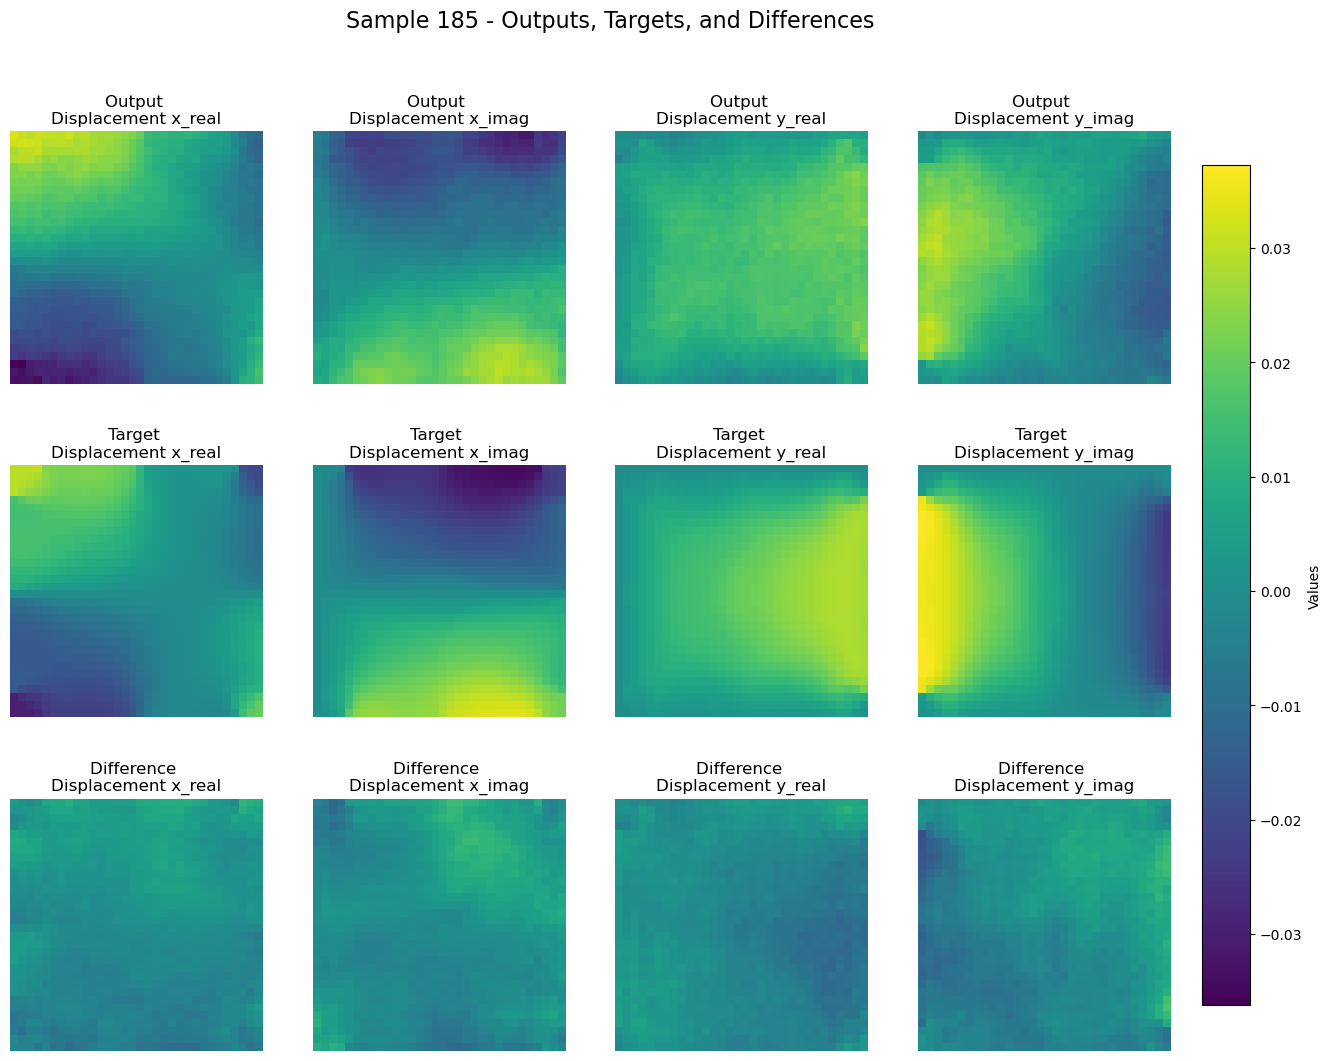

Visualizing sample 242


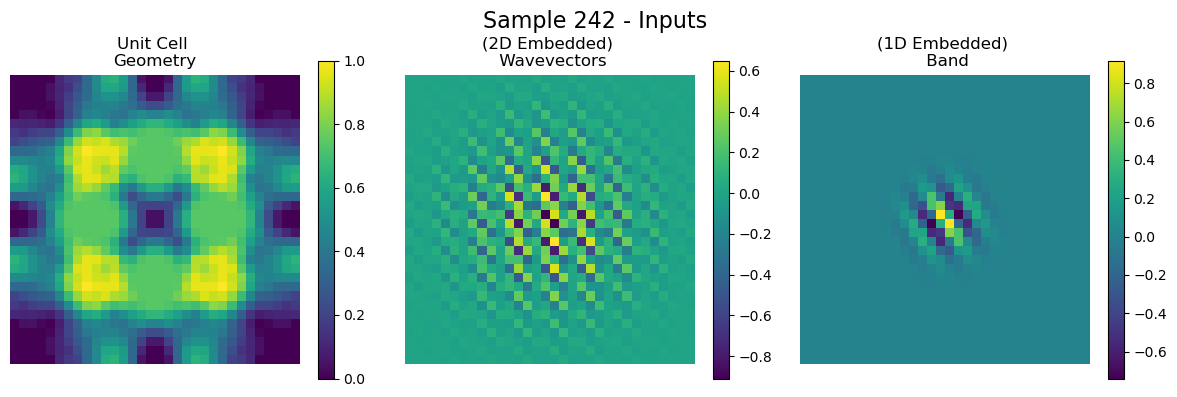

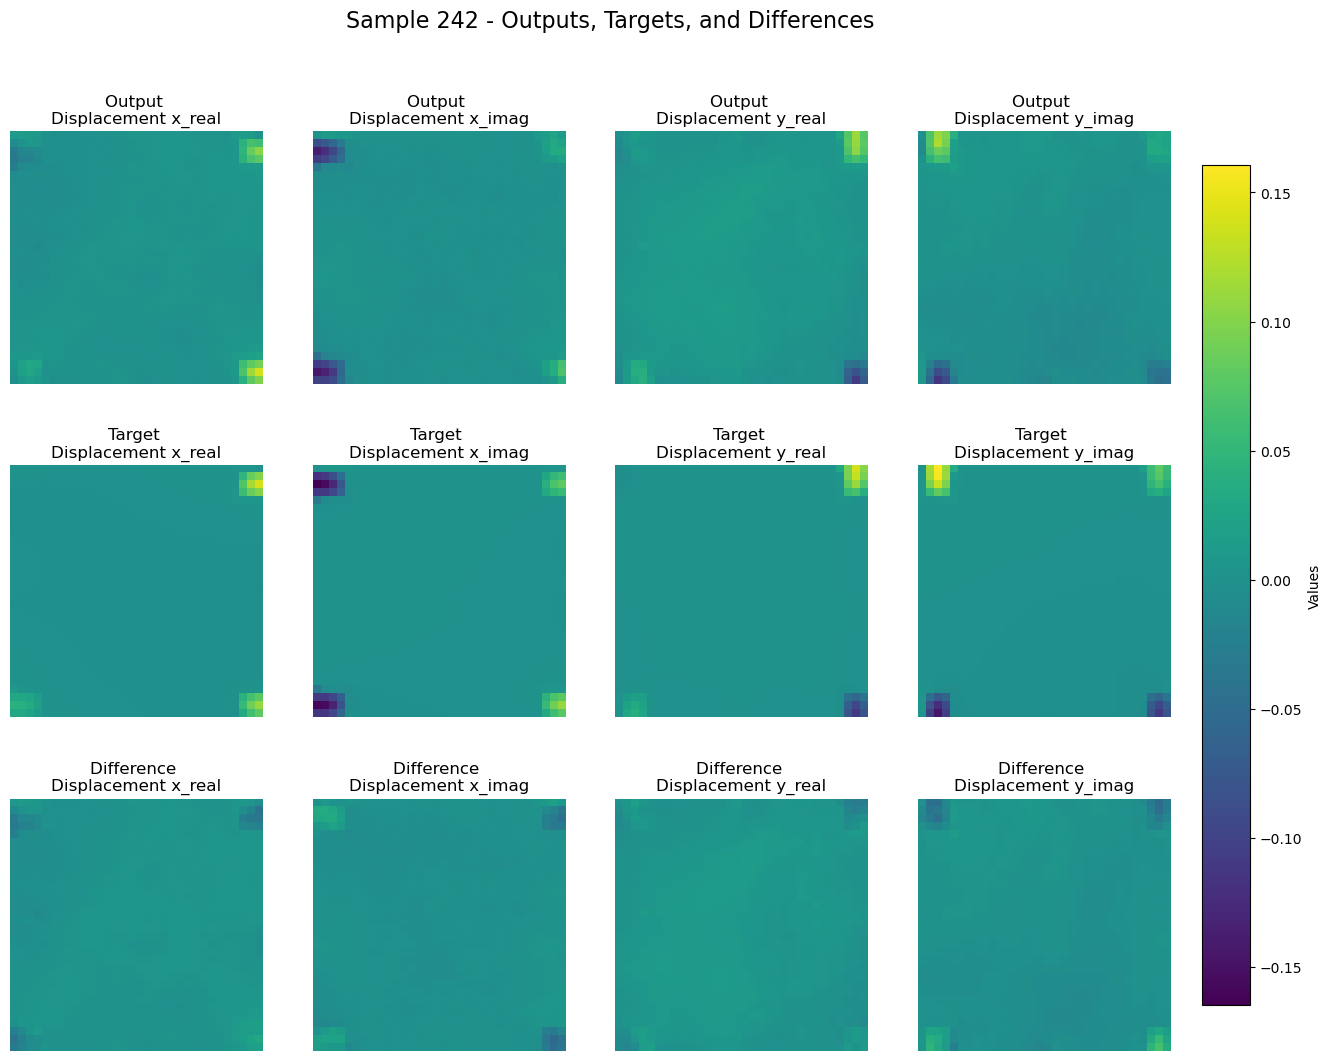

Visualizing sample 167


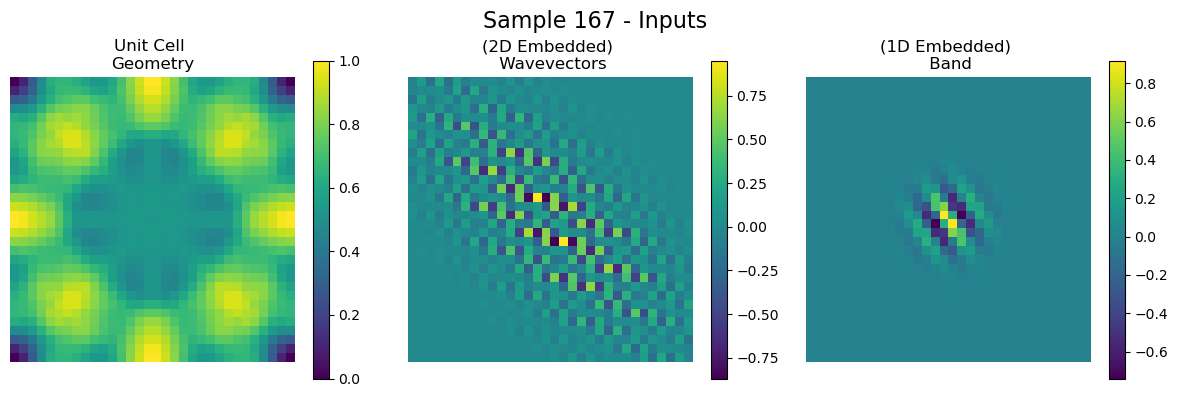

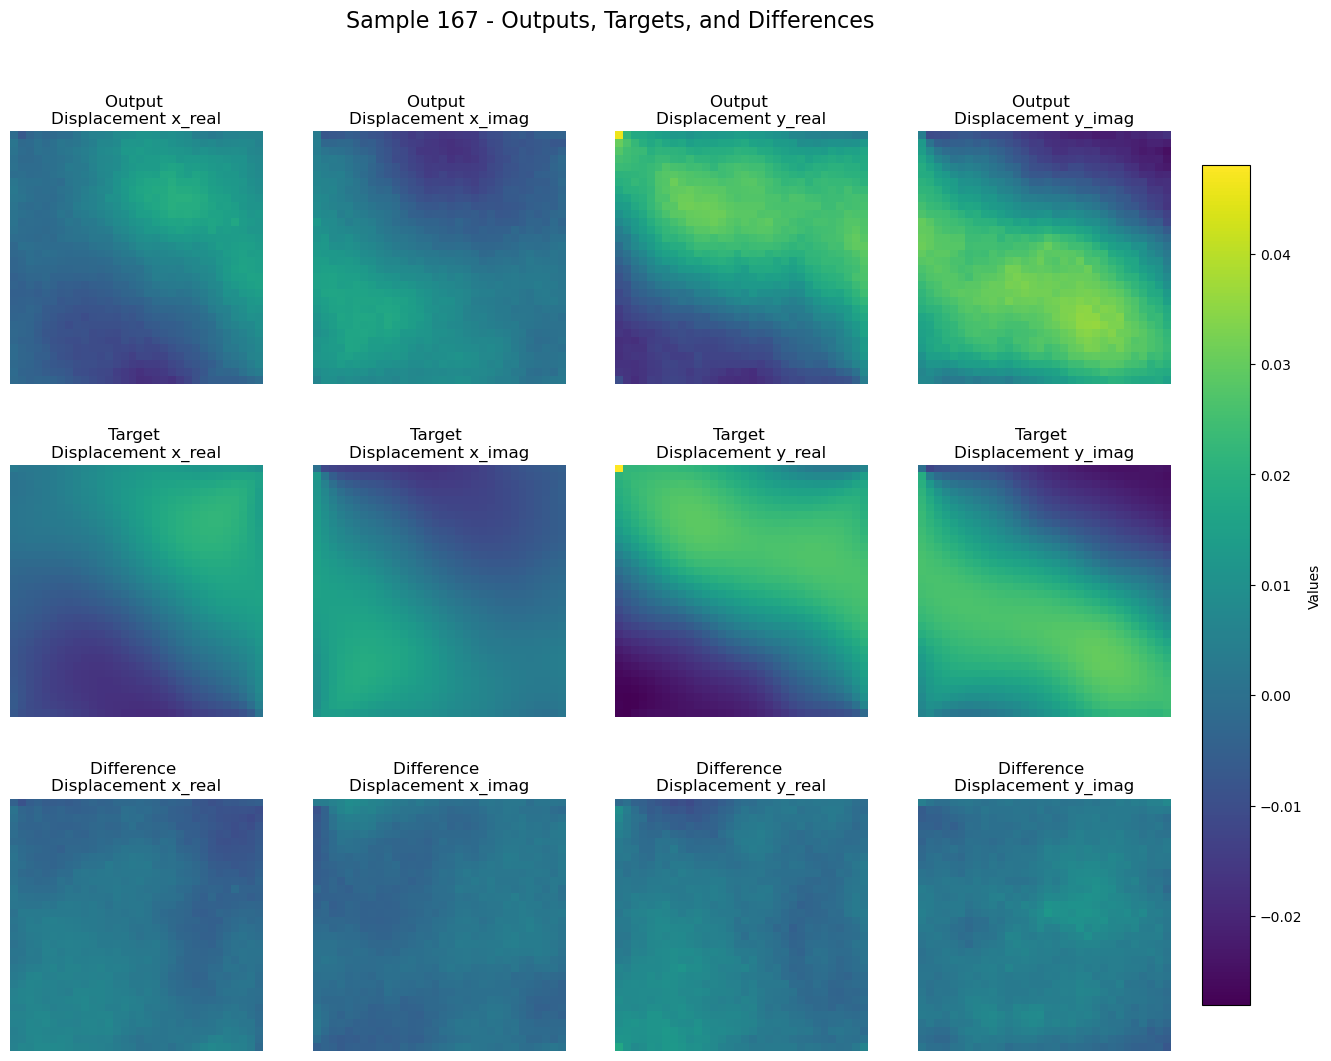

Visualizing sample 9


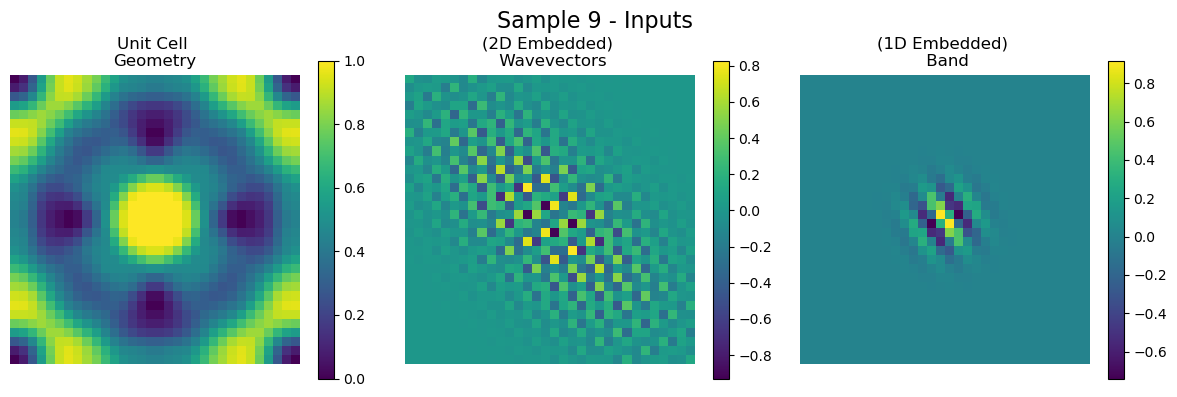

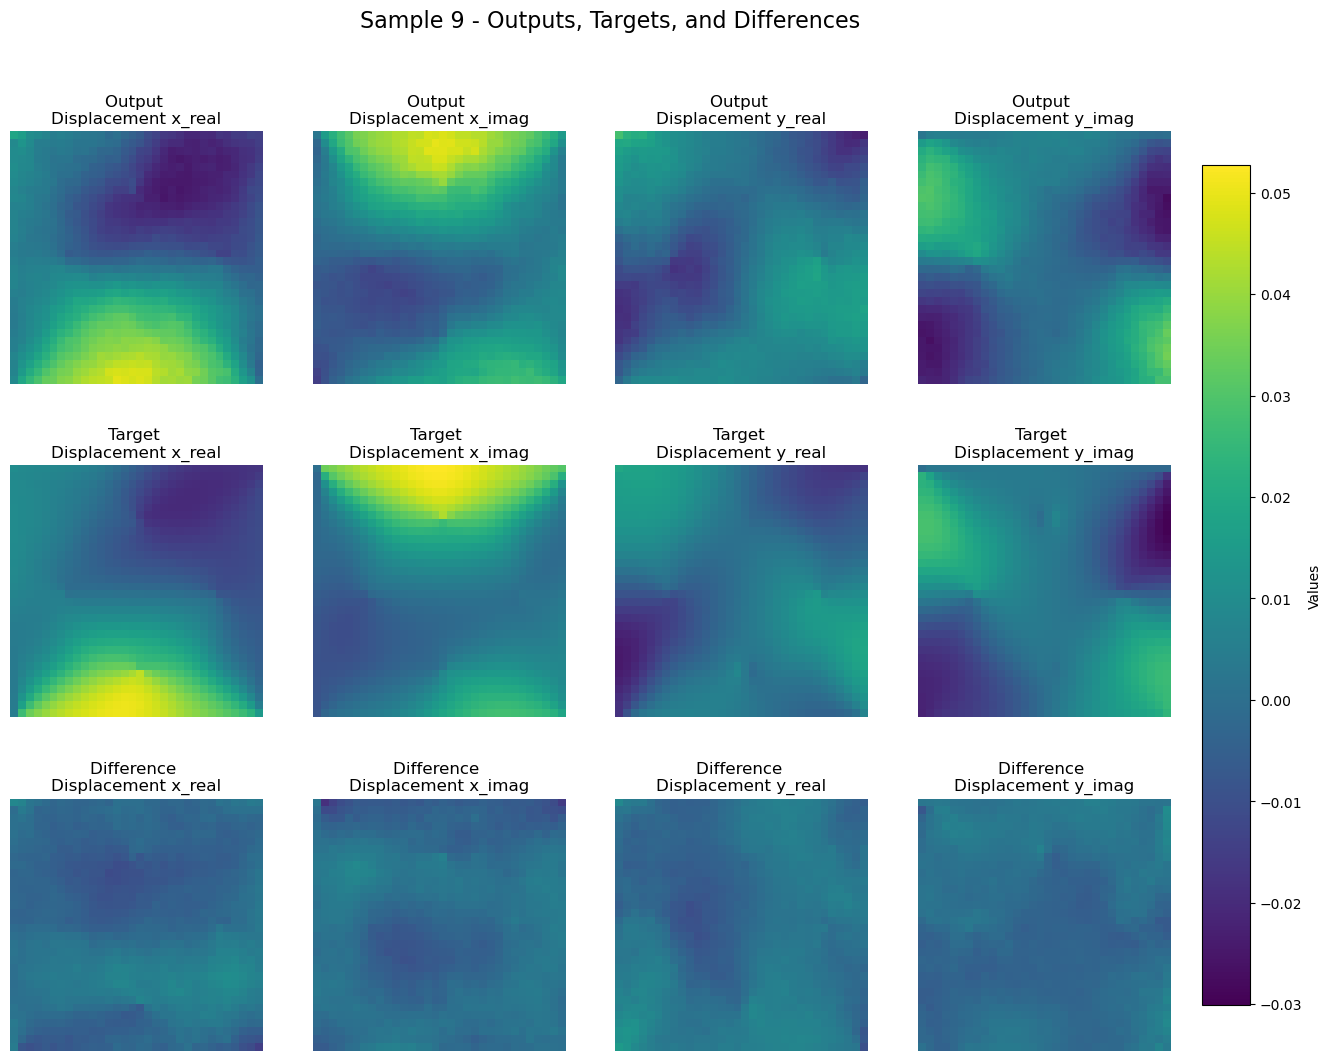

Visualizing sample 30


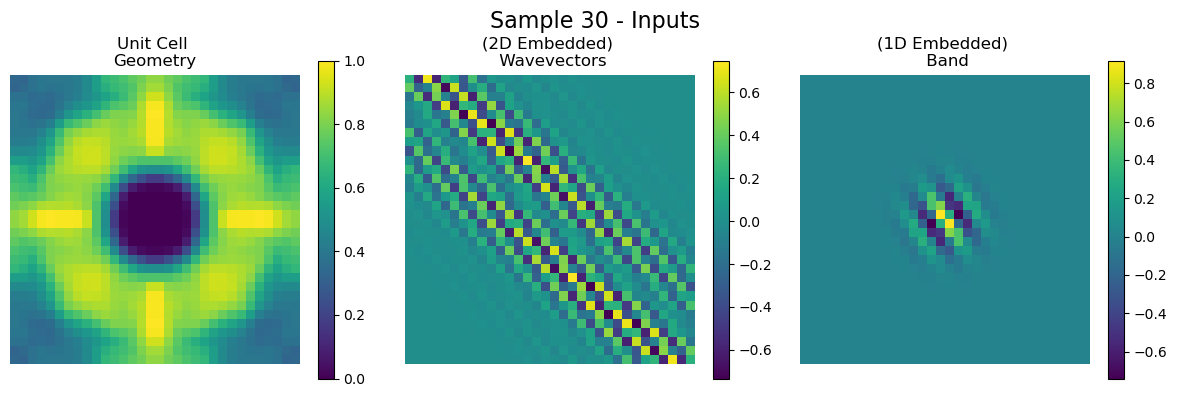

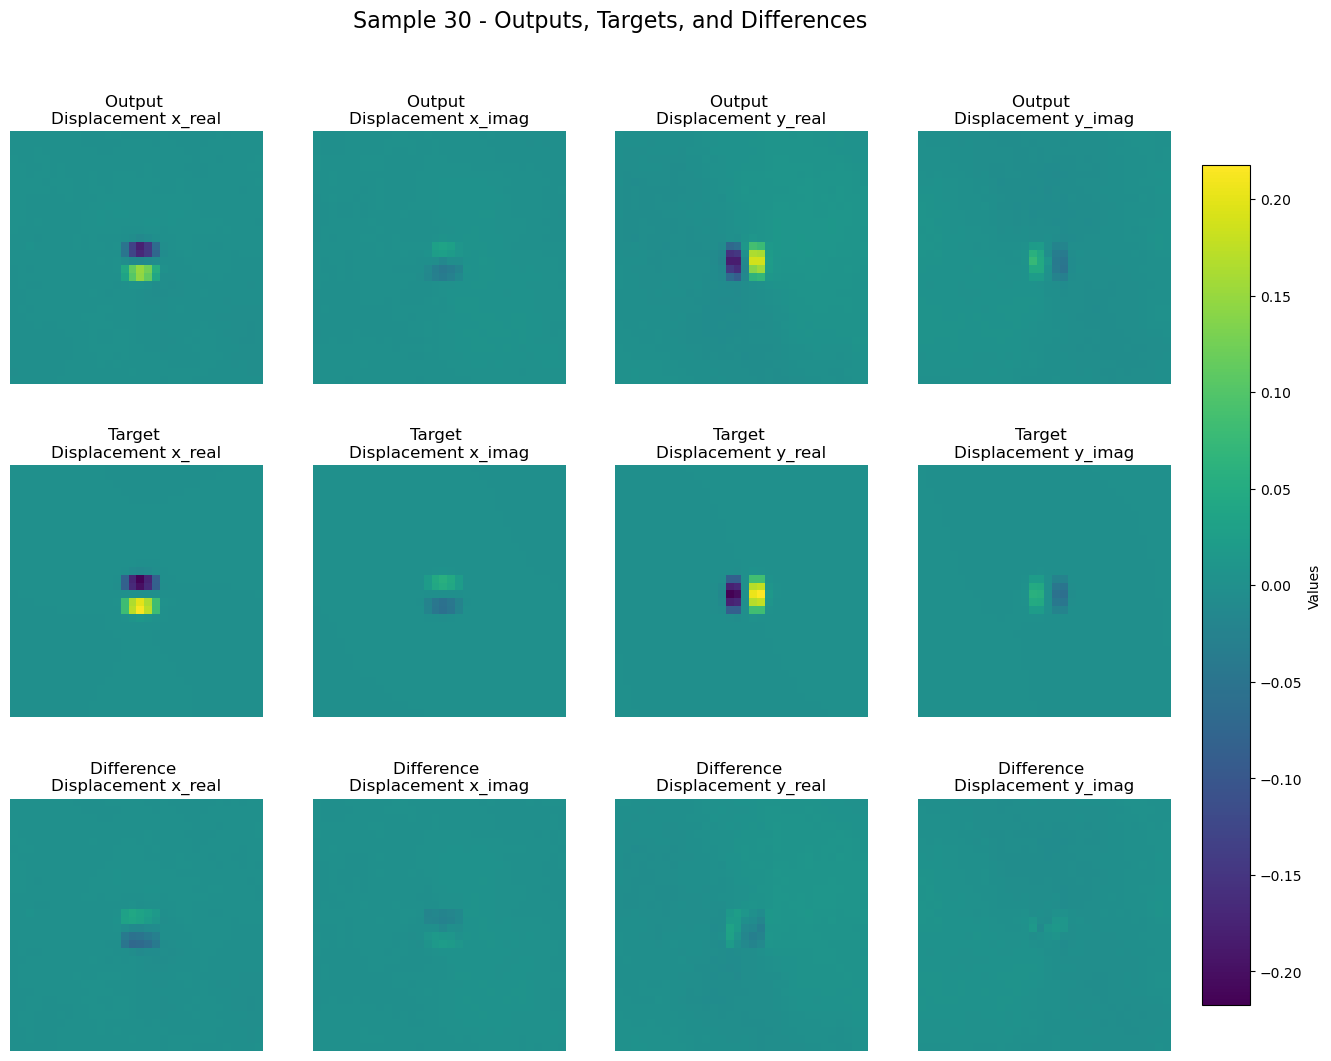

In [16]:
for idx in random_indices:
    print(f"Visualizing sample {idx}")
    input_sample = inputs_np[idx]
    output_sample = outputs_np[idx]
    target_sample = targets_np[idx]
    
    # Plot the 3 inputs in a 1x3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f'Sample {idx} - Inputs', fontsize=16)
    
    input_titles = ['Unit Cell \nGeometry', '(2D Embedded) \n Wavevectors', '(1D Embedded) \n Band']
    
    for i in range(3):
        im = axes[i].imshow(input_sample[i], cmap='viridis')
        axes[i].set_title(input_titles[i])
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i])
    
    plt.tight_layout()
    plt.show()
    
    # Plot outputs, targets, and differences in a 3x4 subplot with shared colorbar
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle(f'Sample {idx} - Outputs, Targets, and Differences', fontsize=16)
    
    # Channel labels
    channel_labels = ["Displacement x_real", "Displacement x_imag", "Displacement y_real", "Displacement y_imag"]
    
    # Find global min/max for outputs and targets to share colorbar
    output_min, output_max = output_sample.min(), output_sample.max()
    target_min, target_max = target_sample.min(), target_sample.max()
    
    # Include differences in the global min/max calculation
    diff_data = []
    for i in range(4):
        diff = output_sample[i] - target_sample[i]
        diff_data.append(diff)
    diff_min = min([d.min() for d in diff_data])
    diff_max = max([d.max() for d in diff_data])
    
    # Global min/max across all data (outputs, targets, and differences)
    global_min = min(output_min, target_min, diff_min)
    global_max = max(output_max, target_max, diff_max)
    
    # Row 1: Outputs
    for i in range(4):
        im = axes[0, i].imshow(output_sample[i], cmap='viridis', vmin=global_min, vmax=global_max)
        axes[0, i].set_title(f'Output \n{channel_labels[i]}')
        axes[0, i].axis('off')
    
    # Row 2: Targets
    for i in range(4):
        im = axes[1, i].imshow(target_sample[i], cmap='viridis', vmin=global_min, vmax=global_max)
        axes[1, i].set_title(f'Target \n{channel_labels[i]}')
        axes[1, i].axis('off')
    
    # Row 3: Differences (Output - Target)
    for i in range(4):
        diff = output_sample[i] - target_sample[i]
        im = axes[2, i].imshow(diff, cmap='viridis', vmin=global_min, vmax=global_max)
        axes[2, i].set_title(f'Difference \n{channel_labels[i]}')
        axes[2, i].axis('off')
    
    # Adjust layout to make room for colorbar
    plt.subplots_adjust(right=0.85, hspace=0.3)
    
    # Add single shared colorbar on the right side
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Values')
    
    plt.show()


In [17]:
# Training loop
num_epochs = 24
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, report_freq=256, save_after_batch=False, save_path=save_path)
    
    val_loss = evaluate(model, val_loader, criterion, device)

    # Print progress for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.10f}, Validation Loss: {val_loss:.10f}")

    # Save losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Step the scheduler
    scheduler.step(val_loss)

timestamp = datetime.now().strftime('%y%m%d-%H%M%S')
# Plot the losses
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.yscale('log')  # Set the y-axis to log scale
plt.savefig(f'loss_plot_L2_{timestamp}.png')  # Save the plot as a PNG file
plt.show()  # Display the plot

NameError: name 'train_loader' is not defined

In [ ]:
# Save the model weights at the end of training
# save_model(model, save_path)sdasdasdas
save_path_posttraining = f'{save_path[:-4]}_e{len(train_losses)}.pth'
save_model(model, save_path_posttraining)
print(f"Saved model weights to {save_path_posttraining}")

Saved model weights to ./model_L2_random_subset_hc128_lr1e-03_wd1e-03_ss4_gamma1e-01_e24.pth


In [ ]:
def plot_model_weights_histogram(model, log_scale=False, print_analytics=False):
    """
    Plots a histogram of the weight values of a given model.
    
    Parameters:
        model: The model object (e.g., PyTorch or TensorFlow model).
        log_scale (bool): If True, the y-axis of the histogram is set to logarithmic scale.
        print_analytics (bool): If True, prints the mean, standard deviation, and total number of weights.
    """
    # Extract all weight values
    weights = []

    # For PyTorch model
    if hasattr(model, "parameters"):
        for param in model.parameters():
            if param.requires_grad:  # Focus only on trainable parameters
                weights.append(param.data.cpu().numpy().flatten())

    # For TensorFlow/Keras model
    elif hasattr(model, "trainable_weights"):
        for layer_weights in model.trainable_weights:
            weights.append(layer_weights.numpy().flatten())

    else:
        raise ValueError("Unsupported model type. The model must be a PyTorch or TensorFlow model.")

    # Flatten and concatenate all weights into a single array
    all_weights = np.concatenate(weights)

    # Print analytics if the flag is set
    if print_analytics:
        mean = np.mean(all_weights)
        std_dev = np.std(all_weights)
        total_weights = all_weights.size
        print(f"Model Weight Analytics:")
        print(f"  Mean: {mean:.4f}")
        print(f"  Standard Deviation: {std_dev:.4f}")
        print(f"  Total Number of Weights: {total_weights}")

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(all_weights, bins=100, alpha=0.75, color='blue', edgecolor='black')
    plt.title("Histogram of Model Weight Values")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")

    if log_scale:
        plt.yscale('log')  # Set y-axis to logarithmic scale
        plt.ylabel("Frequency (log scale)")

    plt.grid(axis='y', alpha=0.75)
    plt.show()

Model Weight Analytics:
  Mean: -0.0001+0.0000j
  Standard Deviation: 0.1236
  Total Number of Weights: 35852932


c:\Users\hz283\AppData\Local\anaconda3\envs\NO_2D_Metamaterials\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\hz283\AppData\Local\anaconda3\envs\NO_2D_Metamaterials\Lib\site-packages\numpy\lib\histograms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
c:\Users\hz283\AppData\Local\anaconda3\envs\NO_2D_Metamaterials\Lib\site-packages\matplotlib\axes\_axes.py:7096: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


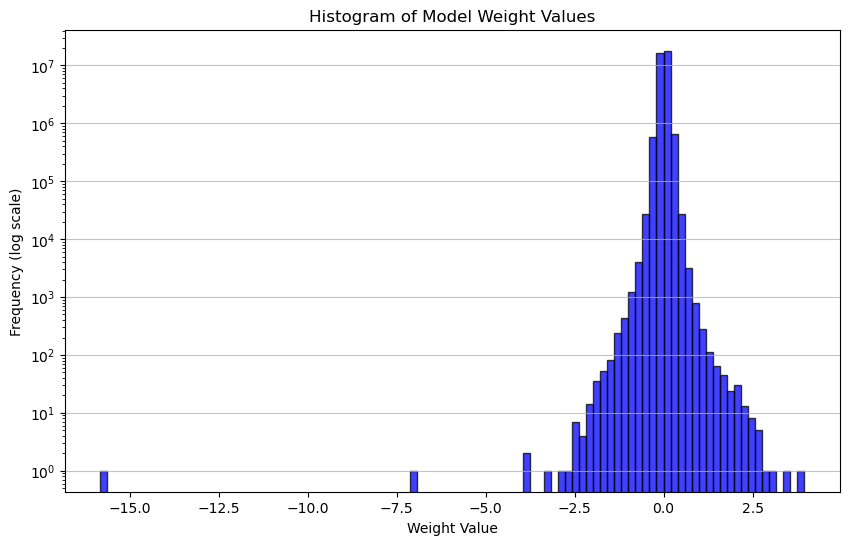

In [ ]:
plot_model_weights_histogram(model, log_scale=True, print_analytics=True)

In [ ]:
initialized_model = FourierNeuralOperator(modes_height=design_res, 
                                          modes_width=design_res, 
                                          in_channels=3, 
                                          out_channels=4, 
                                          hidden=hc,
                                          num_layers=4).to(device)

Model Weight Analytics:
  Mean: 0.0000-0.0000j
  Standard Deviation: 0.0883
  Total Number of Weights: 35852932


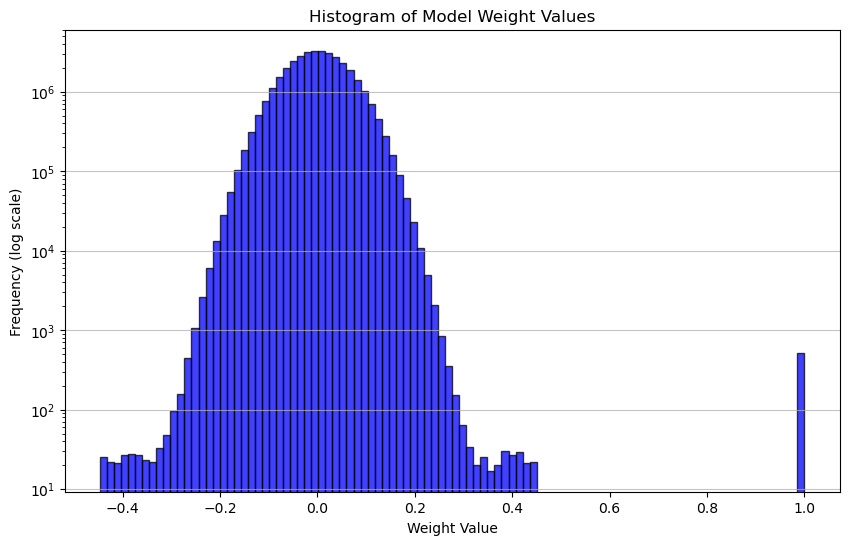

In [ ]:
plot_model_weights_histogram(initialized_model, log_scale=True, print_analytics=True)

## Calculate losses on test dataset using average absolute error to give a training loss agnostic representation of performance

In [ ]:
# Set model to evaluation mode
model.eval()

# Initialize running statistics
running_error_sum = 0
running_error_sq_sum = 0
running_l1_loss = 0
running_count = 0
min_pixel = float('inf')
max_pixel = float('-inf')
pixel_sum = 0

with torch.no_grad():
    for data, target in tqdm(val_loader, desc="Evaluating"):
        # Move data to device if using GPU
        data, target = data.to(device), target.to(device)
        
        # Get model predictions
        output = model(data)
        
        # Calculate absolute percentage error for each pixel
        abs_perc_error = torch.abs((output - target) / (target + 1e-8)) * 100
        
        # Calculate batch statistics
        batch_error = torch.mean(abs_perc_error, dim=(1,2,3))  # Average over all dimensions except batch
        
        # Update running statistics on GPU
        running_error_sum += torch.sum(batch_error)
        running_error_sq_sum += torch.sum(batch_error ** 2)
        running_l1_loss += torch.nn.functional.l1_loss(output, target) * target.size(0)
        running_count += target.size(0)  # Count number of samples, not pixels
        
        # Update pixel statistics on GPU
        min_pixel = min(min_pixel, target.min().item())
        max_pixel = max(max_pixel, target.max().item()) 
        pixel_sum += target.sum().item()

# Calculate final statistics
mean_error = (running_error_sum / running_count).cpu().item()
std_error = torch.sqrt(running_error_sq_sum/running_count - (running_error_sum/running_count)**2).cpu().item()
mean_l1_loss = (running_l1_loss / len(val_loader.dataset)).cpu().item()
mean_pixel = pixel_sum / (running_count * target.size(1) * target.size(2) * target.size(3))

print(f"Test Set Statistics:")
#print(f"Average Sample Percentage Error: {mean_error:.2f}% ± {std_error:.2f}%")
print(f"Average L1 Loss: {mean_l1_loss:.6f}")
print(f"\nDataset Pixel Value Statistics:")
print(f"Min: {min_pixel:.6f}")
print(f"Mean: {mean_pixel:.6f}")
print(f"Max: {max_pixel:.6f}")

Evaluating: 100%|██████████| 1823/1823 [02:07<00:00, 14.34it/s]


Test Set Statistics:
Average L1 Loss: 0.003653

Dataset Pixel Value Statistics:
Min: -0.675293
Mean: -0.000135
Max: 0.642090
